In [1]:
from math import *
import os
import datetime
import copy

import numpy as np
import numpy.ma as ma
import netCDF4

import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

# Defining the quarter degree grid
nx = 1440
ny = 720

# location of data files
fbase = "/Volumes/Data/qdoi/v2.1.nc/"
#file name format: "oisst-avhrr-v02r01.YYYYMMDD.nc"
start = datetime.datetime(1981,9,1)
end = datetime.datetime(2010,8,31)
#debug: end = datetime.datetime(1981,9,30)
dt = datetime.timedelta(1)
tag = start

# quick check that all data files exist
errcount = 0
while (tag <= end and errcount < 90 ):
    fname = "oisst-avhrr-v02r01." + tag.strftime("%Y%m%d") + ".nc"
    if (not os.path.exists(fbase+fname)):
        print("no file for ",fbase+fname)
        errcount += 1
    tag += dt

#debug: print("error count in running over target period:",errcount)
if (errcount != 0):
    print("find the missing data files!")
    exit(1)

# Initialize files for accumulations
sst = np.zeros((ny,nx)) # temporary file for reading in data
tmp = np.zeros((ny,nx))
t0 = np.zeros((ny,nx)) # first sst field, which will be subtracted

# for accumulating moments:
sumx1 = np.zeros((ny,nx))
sumx2 = np.zeros((ny,nx))
sumx3 = np.zeros((ny,nx))
sumx4 = np.zeros((ny,nx))

# for trend computation
sumt = 0
sumxt = np.zeros((ny,nx))
sumt2 = np.zeros((ny,nx))
days = 0 # starting time = 0 at first date of the record


# extrema
tmax = np.zeros((ny,nx))
tmin = np.zeros((ny,nx))
tmax.fill(-3.0)
tmin.fill(45.0)
# numpy.fmax(f1,f2)

# for accumulating harmonics


In [2]:

def findmask(mask, sst):
    #debug: print("mask ",mask.max(), mask.min(), sst.max(), sst.min(), flush = True)
    tmask =  ma.masked_array(sst < -900.*30)
    mask = ma.mask_or(mask, tmask)

    indices = tmask.nonzero()
    #debug: print("later-t ",  len(indices[0]) )
    del tmask

    indices = mask.nonzero()
    #debug: print("later ",  len(indices[0]) )
    return indices

def applymask(mask, grid, indices):
  #debug: print("applymask", indices[0])
  for k in range(0, len(indices[0])):
    i = indices[1][k]
    j = indices[0][k]
    grid[j,i] = 0.


In [3]:
# Now run through the data files and accumulate terms:

tag = start
#debug: 
end = datetime.datetime(1981,9,30)
days = 0
while (tag <= end ):
# Get the day's data:
    fname = "oisst-avhrr-v02r01." + tag.strftime("%Y%m%d") + ".nc"
    tmpnc = netCDF4.Dataset(fbase + fname)
    sst = tmpnc.variables['sst'][0,0,:,:]
    if ( days == 0 ):
        t0 = copy.deepcopy(sst)
        lons = tmpnc.variables['lon'][:]
        lats = tmpnc.variables['lat'][:]
    tmpnc.close()

# Accumulate moments:
    tmp = copy.deepcopy(sst)
    #debug: print("moment1", tag, tmp.max(), tmp.min(), flush=True )
    sumx1 += tmp
    tmp *= sst
    #debug: print("moment2",tag, tmp.max(), tmp.min() )
    sumx2 += tmp
    tmp *= sst
    sumx3 += tmp
    tmp *= sst
    sumx4 += tmp
    #debug: print("moment4",sumx4.max(), sumx4.min() )

# Accumulate for trends:
    tmp = copy.deepcopy(sst)
    #debug: print("trends ",tmp.max(), tmp.min() )
    tmp *= days
    sumxt += tmp
    tmp.fill(days*days)
    #debug: print(tmp.max(), tmp.min() )
    sumt2 += tmp
    sumt += days

# Find extrema:
    tmax = np.fmax(tmax, sst)
    tmin = np.fmin(tmin, sst)
    #debug: print("tmax ",tmax.max(), tmax.min() )
    #debug: print("tmin ",tmin.max(), tmin.min() )
    
    days += 1
    tag += dt




In [4]:
#RG: write out mean, max, min to save file
mask =  ma.masked_array(sumx1 < -900.*days)
indices = findmask(mask, sumx1)
indices = findmask(mask, sumx2)
indices = findmask(mask, sumx3)
indices = findmask(mask, sumx4)

print("sumx1", sumx1.max(), sumx1.min() )
print("sumx2", sumx2.max(), sumx2.min() )
print("sumx3", sumx3.max(), sumx3.min() )
print("sumx4", sumx4.max(), sumx4.min() )

#
print("sumxt", sumxt.max(), sumxt.min() )
print("sumt2", sumt2.max(), sumt2.min() )
print("sumt",sumt, sumt/days)
print("days",days)


sumx1 990.5299777984619 -29970.0
sumx2 32718.016479492188 -29970.0
sumx3 1081130.78515625 -29970.0
sumx4 35738832.375 -29970.0
sumxt 14270.20958328247 -29970.0
sumt2 8555.0 8555.0
sumt 435 14.5
days 30


Embrace the masked array:


691150 True False
[    0     0 57631 68943 15195 13015  8639  7160  7492  7264  5975  5479
  5564  5239  5766  5988  5927  6563  6232  6295  5784  6296  7845  7519
  7228  7302  7939  7112  7145  7594  7598  7550  7036  6569  6276  7025
  6463  6428  6445  6772  6043  6236  6144  6757  6854  7354  7136  7118
  7448  8688  8623  8455  9290 10187 10705 10953 15676 16008 15198 17059
 20577 24591 22318 25834 13690  5557  1502   275   172   164   126   116
     3     0     0     0     0     0     0     0]
[-3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5
  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5
 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5
 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5
 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37. ]


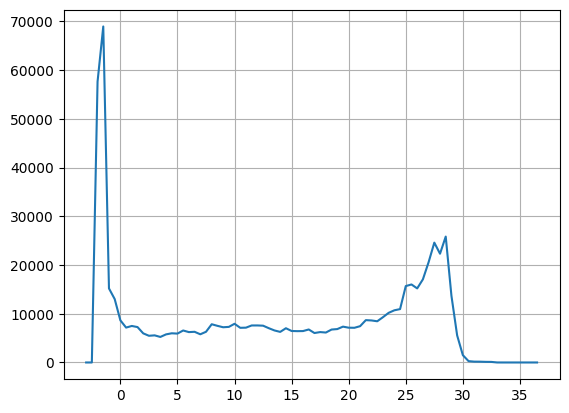

In [5]:
#take a look at the histogram of mean temperatures:
mean = sumx1 / days
masked_mean = ma.masked_array(mean, mask)
mask = masked_mean.mask
nbins = 80
hist,binedges = np.histogram(masked_mean, bins = nbins, range = [-3,37] )

print(masked_mean.count(), mask.max(), mask.min()  )

#debug: 
print(hist)
#debug: 
print(binedges, flush=True)

fig,ax = plt.subplots()
plt.grid(visible=True)
ax.plot(binedges[0:nbins], hist)
plt.show()
plt.close()

##this is really, really slow:
#plt.hist(sst, bins = binedges)
#plt.title("Histogram")
#plt.show()
#plt.close()

691150
[203686  17501  15031  12126  11577  12199  10438  10402   9227   8659
   8770   8170   7886   6638   5972   6446   6220   5576   5514   5447
   5616   4901   4682   4852   4552   4824   5058   4744   5123   4788
   4884   4727   4559   4931   5473   5439   5245   5204   4950   5374
   5800   5736   5954   6157   5764   6361   8235   9296   8678   7491
   8002   8002   8598   9397  10270  11955  12479  10899  10605  11130
  12895  11439   7125   4037   3021   1961   1113    439    138    126
     85     74     90     76     51     64     47     54     53     42]
[    0.           408.97520599   817.95041199  1226.92561798
  1635.90082397  2044.87602997  2453.85123596  2862.82644196
  3271.80164795  3680.77685394  4089.75205994  4498.72726593
  4907.70247192  5316.67767792  5725.65288391  6134.6280899
  6543.6032959   6952.57850189  7361.55370789  7770.52891388
  8179.50411987  8588.47932587  8997.45453186  9406.42973785
  9815.40494385 10224.38014984 10633.35535583 11042.3305618

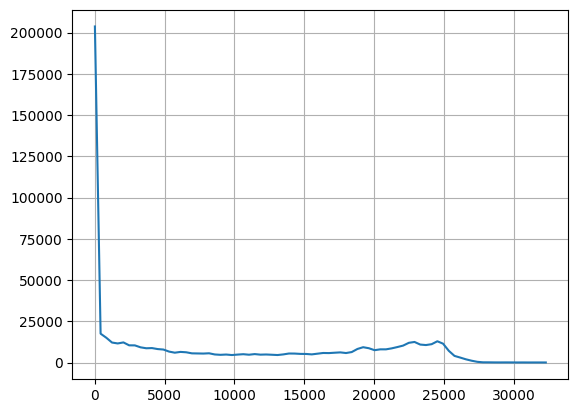

In [6]:
#try looking at histogram of sumx2:
print(masked_mean.count() )

nbins = 80
masked_sumx2 = ma.masked_array(sumx2, mask)
hist,binedges = np.histogram(masked_sumx2, bins = nbins, range = [0,masked_sumx2.max() ])

#debug: 
print(hist)
#debug: 
print(binedges, flush=True)
print("sumx2, masked_sumx2: ",masked_sumx2.count(), masked_sumx2.min() )

fig,ax = plt.subplots()
plt.grid(visible=True)
ax.plot(binedges[0:nbins], hist)
plt.show()
plt.close()

691150 691150
[345650      0 247041  31096  22104  17206  14768  11394   9729   9208
   8044   7590   7323   6126   6093   5667   5988   5707   5792   5469
   5435   5118   4974   5375   5658   5589   5280   5041   4931   5414
   5556   5618   5562   5624   5306   5784   6997   8224   8060   7026
   6556   6963   6771   7191   7924   8214   9010  10118  10196   8842
   8558   8597   9131  10285   9128   6713   4113   2851   2327   1606
   1243    641    331    111     92     95     65     50     52     67
     66     32     44     47     29     37     39     38     30     30]
[ -29970.          -16081.24018555   -2192.48037109   11696.27944336
   25585.03925781   39473.79907227   53362.55888672   67251.31870117
   81140.07851563   95028.83833008  108917.59814453  122806.35795898
  136695.11777344  150583.87758789  164472.63740234  178361.3972168
  192250.15703125  206138.9168457   220027.67666016  233916.43647461
  247805.19628906  261693.95610352  275582.71591797  289471.47573242
  30

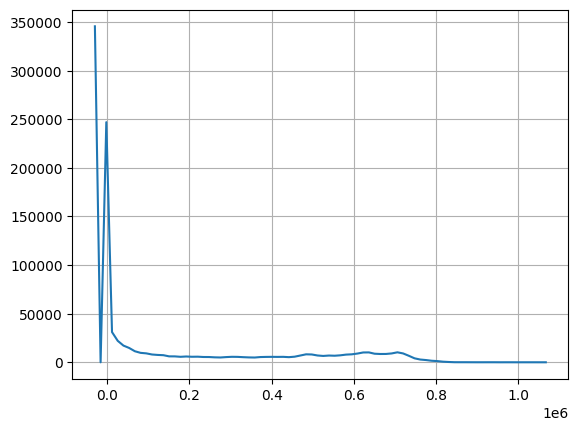

In [7]:

#try looking at histogram of sumx3:
nbins = 80
masked_sumx3 = ma.masked_array(sumx3, mask)
print(masked_sumx3.count(), masked_mean.count() )
hist,binedges = np.histogram(masked_sumx3, bins = nbins )

#debug: 
print(hist)
#debug: 
print(binedges, flush=True)
print(sumx3.min(), masked_sumx3.min() )

fig,ax = plt.subplots()
plt.grid(visible=True)
ax.plot(binedges[0:nbins], hist)
plt.show()
plt.close()

[986590  21836   8686   4727   3102   1977   1338   1188   1115    987
    820    651    505    440    373    298    263    198    145    130
    114    107     97    111     83     82     99     77     54     56
     24     33     29     18     29     23     25     29     21     27
     26     19     15     20     24     12      7      6      5      4
      3      3      3      4      8      8      3      4      2      4
      5      3      7      2      5      5      1      1      3      1
      8      7      5      5      4      7     15      7     15      7]
[0.00000000e+00 1.84191343e+07 3.68382687e+07 5.52574030e+07
 7.36765373e+07 9.20956716e+07 1.10514806e+08 1.28933940e+08
 1.47353075e+08 1.65772209e+08 1.84191343e+08 2.02610478e+08
 2.21029612e+08 2.39448746e+08 2.57867881e+08 2.76287015e+08
 2.94706149e+08 3.13125284e+08 3.31544418e+08 3.49963552e+08
 3.68382687e+08 3.86801821e+08 4.05220955e+08 4.23640090e+08
 4.42059224e+08 4.60478358e+08 4.78897492e+08 4.97316627e+08
 5.1

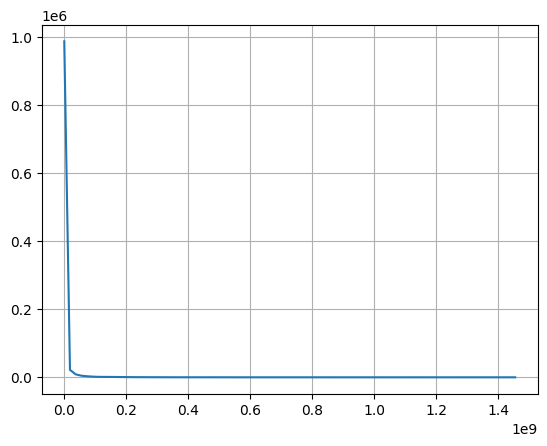

In [110]:
#sumx4: 
#try looking at histogram of sumx4:
nbins = 80
hist,binedges = np.histogram(sumx4, bins = nbins)

#debug: 
print(hist)
#debug: 
print(binedges, flush=True)
print((sumx4.max()/days)**0.25,10.**0.25)

fig,ax = plt.subplots()
plt.grid(visible=True)
ax.plot(binedges[0:nbins], hist)
plt.show()
plt.close()

In [111]:
sum = 0
for k in range (0,days):
    sum += k
print(k,sum/days, days/2)

# Take a look at trends/linear regression
print(sumt2.max(), sumt2.max()/days, sqrt(sumt2.max()/days) )
ym = np.zeros((ny,nx))
ym.fill((days+1)/2.)
xm = np.fmax(-1.7, sumx1 / days)

tmp = sumx2 - days*xm*xm
print("tmp",tmp.min())
tmp = np.fmax(0,tmp)
sigx = np.sqrt(tmp)
sigy = np.sqrt(sumt2 - days*ym*ym)
print("sigx",sigx.max(), sigx.min() )
print("sigy",sigy.max(), sigy.min() )

b = (sumxt - days*xm*ym)/(sumx2 - days*xm*ym)
a = ym - b*xm
r = (sumxt - days*xm*ym)/sigx/sigy

print("a",a.max(), a.min())
print("b", b.max(), b.min() )
print("r", r.max(), r.min() )


10591 5295.5 5296.0
396051032448.0 37391524.96676737 6114.860993249754
tmp -30610.879999999994
sigx 1698.8399633359043 0.0
sigy 314506.89324083185 314506.89324083185
a 5298.011384876805 5285.089829527227
b 7147.7385826727495 -9475.847814747582
r inf -1.3851013459340307


/var/folders/2d/0ghjf6hs3x993y90thd8nfpc0000gp/T/ipykernel_30502/4278957218.py:22: RuntimeWarning: divide by zero encountered in divide
  r = (sumxt - days*xm*ym)/sigx/sigy


In [112]:
tmp = np.zeros((ny,nx))

variance = sumx2/days - mean*mean
print(variance.max(), sqrt(variance.max() ), variance.min()  )
variance = np.fmax(tmp, variance)
sigma = np.sqrt(variance)
print(sigma.max(), sqrt(3993003.) )

96.23817858378578 9.81010594151693 -998001.0
9.81010594151693 1998.2499843613161


In [113]:
# work in progress

#skew = E(((X-mean)/sigma)^3) = (E(X^3) - 3*mu*sigma^2 - mu^3) / sigma^3
skew_unscaled = (sumx3 - 3*mean*sigma*sigma)/days + 2*mean**3 
print(skew_unscaled.max() , skew_unscaled.min() )
#skew = skew_unscaled / sigma^3-where sigma != 0

kurtosis_unscaled = 0 #E((X-mean)^4)
#kurtosis = E(((X-mean)/sigma^2)^4) = E(X - mean)^4 / sigma**4

1617.9493164605797 -1994006997.0


vmin max =  -3 7.98040529716411


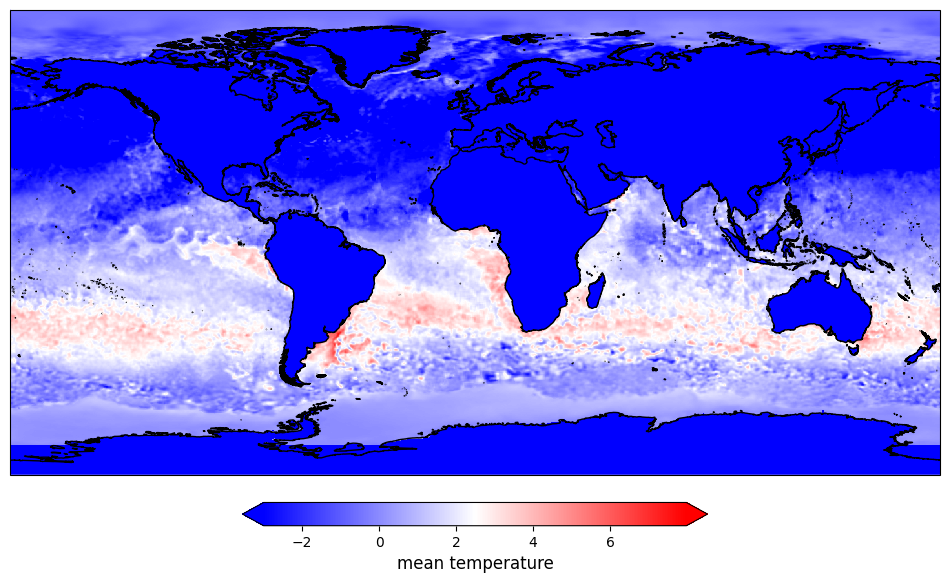

vmin max =  0.0 9.81010594151693


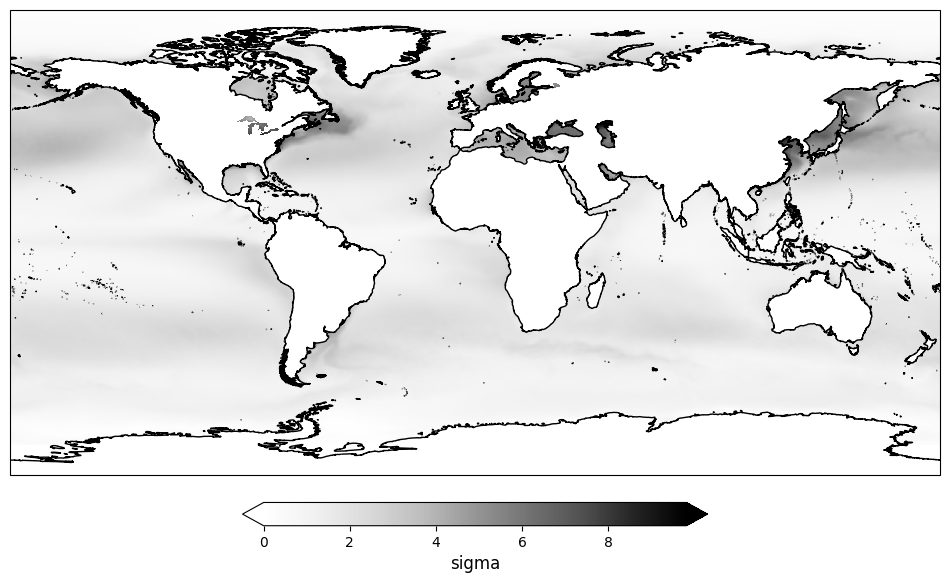

In [114]:
# Try a simple geographic plot
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

proj = ccrs.PlateCarree()

# plot the mean -- remember we computed mean difference from the first grid seen:
vmin = max(-3,np.nanmin(mean))
vmax = np.nanmax(mean)
print("vmin max = ",vmin, vmax, flush=True)

#colors = matplotlib.colormaps.get_cmap('terrain')
#colors = matplotlib.colormaps.get_cmap('seismic')
colors = matplotlib.colormaps.get_cmap('bwr')

fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1, projection = proj)
ax.coastlines(resolution='10m')

cs = ax.pcolormesh(lons, lats, mean, vmin=vmin,vmax=vmax,cmap=colors, transform=ccrs.PlateCarree() )
cb = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.5, pad=.04)
cbarlabel = '%s' % ("mean temperature")
cb.set_label(cbarlabel, fontsize=12)

plt.show()
plt.close()

# sigma
colors = matplotlib.colormaps.get_cmap('Greys')

fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1, projection = proj)
ax.coastlines(resolution='10m')

vmin = np.nanmin(sigma)
vmax = np.nanmax(sigma)
print("vmin max = ",vmin, vmax, flush=True)
cs = ax.pcolormesh(lons, lats, sigma,vmin=vmin,vmax=vmax,cmap=colors, transform=ccrs.PlateCarree() )
cb = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.5, pad=.04)
cbarlabel = '%s' % ("sigma")
cb.set_label(cbarlabel, fontsize=12)

plt.show()
plt.close()

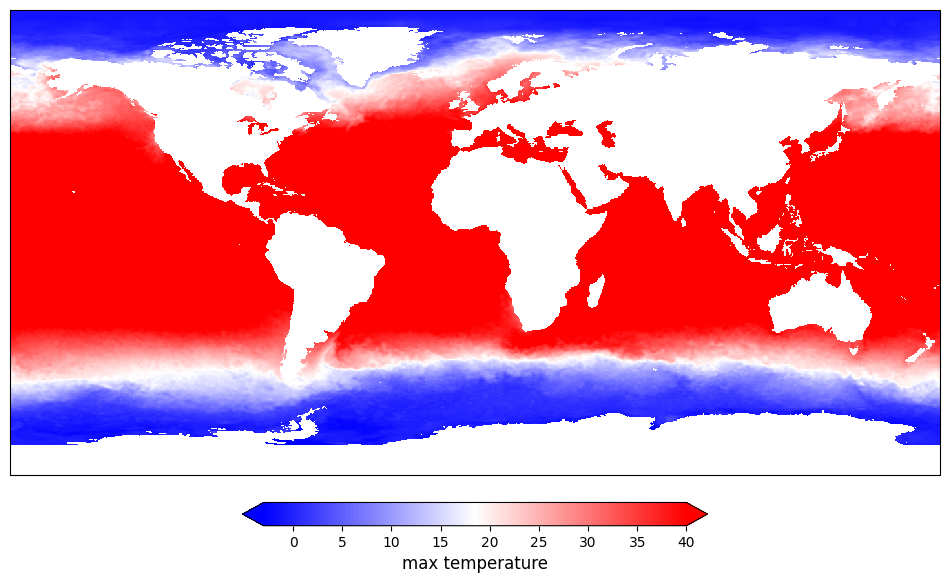

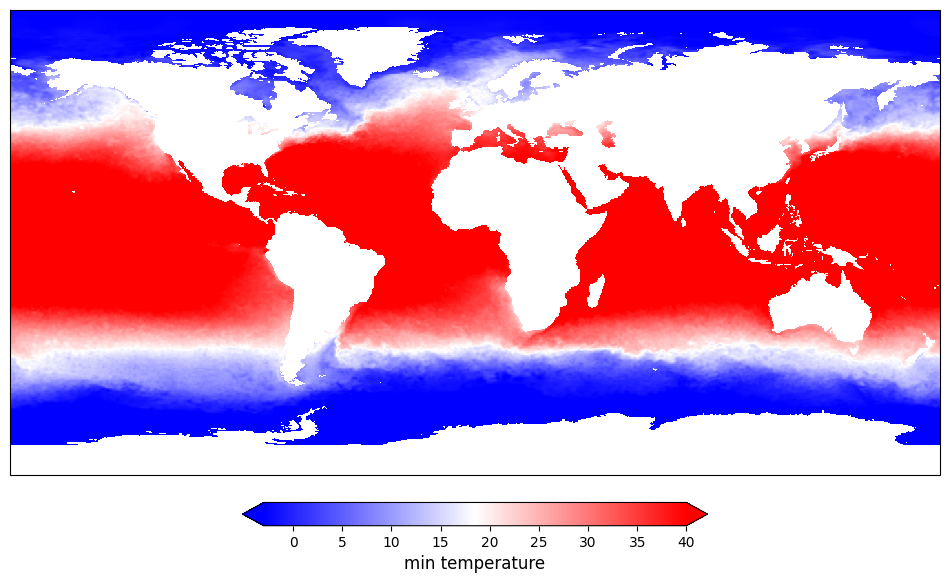

In [115]:
#Show tmax, tmin:
tmax += t0
tmin += t0
vmin = -3.
vmax = 40.

colors = matplotlib.colormaps.get_cmap('bwr')

#tmax
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1, projection = proj)

cs = ax.pcolormesh(lons, lats, tmax, vmin=vmin,vmax=vmax,cmap=colors, transform=ccrs.PlateCarree() )
cb = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.5, pad=.04)
cbarlabel = '%s' % ("max temperature")
cb.set_label(cbarlabel, fontsize=12)

plt.show()
plt.close()

#tmin
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1, projection = proj)

cs = ax.pcolormesh(lons, lats, tmin, vmin=vmin,vmax=vmax,cmap=colors, transform=ccrs.PlateCarree() )
cb = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.5, pad=.04)
cbarlabel = '%s' % ("min temperature")
cb.set_label(cbarlabel, fontsize=12)

plt.show()
plt.close()



[    0     0 65651 50330 24646 14922  9587  8969  8085  7074  6572  6289
  5974  6346  6642  6679  6961  7265  6840  7013  6962  6788  6805  6523
  6663  6606  6093  5735  5489  5194  5224  5092  5019  5087  5194  5855
  6133  5859  6041  6000  6245  6738  7524  7396  7793  8076  8040  8177
  8717  8977  9000  9631  9688 10186 11302 11631 12257 15358 17172 21188
 26203 28060 21770 24274 11301   239     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[-3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5
  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5
 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5
 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5
 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37. ]


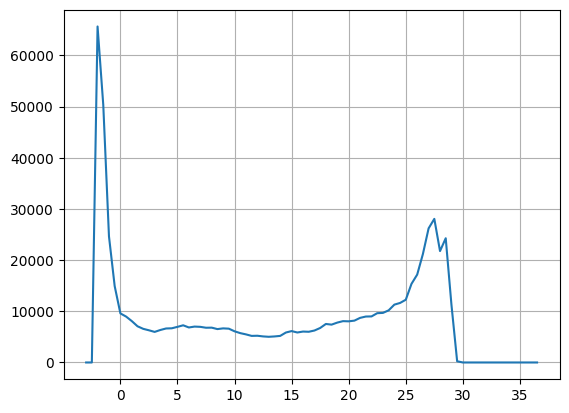

In [118]:
#RG: Properly, this needs to be weighted by latitude (area)

nbins = 80
tmp = mean + t0
hist,binedges = np.histogram(tmp, bins = nbins, range = [-3,37] )

#debug: 
print(hist)
#debug: 
print(binedges, flush=True)

fig,ax = plt.subplots()
plt.grid(visible=True)
ax.plot(binedges[0:nbins], hist)
plt.show()
plt.close()


In [117]:
#write out mean, sigma, skew, kurtosis, linear regression (a,b), harmonics from first pass